# 1. 目次情報の分析

`data`にある`wj-api.json`等のデータを使って遊んでみます．

## 環境構築

```bash
conda env create -f env.yml
```

## 準備
日本語で漫画のタイトルを表示したいので，[matplotlibで日本語を描画 on Ubuntu](http://qiita.com/conta_/items/4b031a44acceb137ec73)を参考に設定します．Ubuntu以外をお使いの方は，適宜ご対応ください．

In [1]:
%matplotlib inline

import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style='ticks')

import matplotlib
from matplotlib.font_manager import FontProperties
font_path = '/usr/share/fonts/truetype/takao-gothic/TakaoPGothic.ttf'
font_prop = FontProperties(fname=font_path)
matplotlib.rcParams['font.family'] = font_prop.get_name()

## ComicAnalyzer
雑誌分析用に，`ComicAnalyzer`クラスを定義します．

In [2]:
class ComicAnalyzer():
    """漫画雑誌の目次情報を読みだして，管理するクラスです．"""
    
    def __init__(self, data_path='data/wj-api.json', min_week=7, short_week=10):
        """
        初期化時に，data_pathにある.jsonファイルから目次情報を抽出します．
        - self.data: 全目次情報を保持するリスト型
        - self.all_titles: 全作品名情報を保持するリスト型
        - self.serialized_titles: min_week以上連載した全作品名を保持するリスト型
        - self.last_year: 最新の目次情報の年を保持する数値型
        - self.last_no: 最新の目次情報の号数を保持する数値型
        - self.end_titles: self.serialized_titlesのうち，self.last_yearおよび
                           self.last_noまでに終了した全作品名を保持するリスト型
        - self.short_end_titles: self.end_titlesのうち，short_week週以内に
                                 連載が終了した作品名を保持するリスト型
        - self.long_end_titles: self.end_titlesのうち，short_week+1週以上に
                                連載が継続した作品名を保持するリスト型
        """
        
        self.data = self.read_data(data_path)
        self.all_titles = self.collect_all_titles()
        self.serialized_titles = self.drop_short_titles(self.all_titles, min_week)
        self.last_year = self.find_last_year(self.serialized_titles[-100:])
        self.last_no = self.find_last_no(self.serialized_titles[-100:], self.last_year)
        self.end_titles = self.drop_continued_titles(
            self.serialized_titles, self.last_year, self.last_no)
        self.short_end_titles = self.drop_long_titles(
            self.end_titles, short_week)
        self.long_end_titles = self.drop_short_titles(
            self.end_titles, short_week + 1)

    def read_data(self, data_path):
        """ data_pathにあるjsonファイルを読み出して，全ての目次情報をまとめたリストを返します． """
        with open(data_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        return data

    def collect_all_titles(self):
        """ self.dataから全ての作品名を抽出したリストを返します． """
        titles = []
        for comic in self.data:
            if comic['title'] not in titles:
                titles.append(comic['title'])
        return titles

    def extract_item(self, title='ONE PIECE', item='worst'):
        """ self.dataからtitleのitemをすべて抽出したリストを返します． """
        return [comic[item] for comic in self.data if comic['title'] == title]

    def drop_short_titles(self, titles, min_week):
        """ titlesのうち，min_week週以上連載した作品名のリストを返します． """
        return [title for title in titles
                if len(self.extract_item(title)) >= min_week]

    def drop_long_titles(self, titles, max_week):
        """ titlesのうち，max_week週以内で終了した作品名のリストを返します． """
        return [title for title in titles
                if len(self.extract_item(title)) <= max_week]

    def find_last_year(self, titles):
        """ titlesが掲載された雑誌のうち，最新の年を返します． """
        return max([self.extract_item(title, 'year')[-1]
                   for title in titles])

    def find_last_no(self, titles, year):
        """ titlesが掲載されたyear年の雑誌のうち，最新の号数を返します． """
        return max([self.extract_item(title, 'no')[-1]
                   for title in titles
                   if self.extract_item(title, 'year')[-1] == year])

    def drop_continued_titles(self, titles, year, no):
        """ titlesのうち，year年のno号までに連載が終了した作品名のリストを返します． """
        end_titles = []
        for title in titles:
            last_year = self.extract_item(title, 'year')[-1]
            if last_year < year:
                end_titles.append(title)
            elif last_year == year:
                if self.extract_item(title, 'no')[-1] < no:
                    end_titles.append(title)
        return end_titles

    def search_title(self, key, titles):
        """ titlesのうち，keyを含む作品名のリストを返します． """
        return [title for title in titles if key in title]

かなりわかりづらい処理をしているので，初期化時（`__init__()`）の動作を補足します．
1. `self.all_titles`は文字通り全ての作品名を保持します．しかし，`self.all_titles`は，明らかに読みきり作品や企画作品を含んでしまっています．
2. そこで，`min_week`以上連載した作品`self.serialized_titles`として抽出します．しかし，`self.serialized_titles`は，データベースの最新の目次情報の時点で，連載を継続中の作品を含んでおり，連載継続期間が不正確になってしまいます．例えば，「[鬼滅の刃](https://mediaarts-db.bunka.go.jp/mg/magazine_works/25517?)」など現在も連載中の人気作が，21週で連載が終了した作品のように見えてしまいます．
3. そこで，データベースの最新の目次情報の時点で連載が終了した（と思われれる）作品のみを`self.end_titles`として抽出します．`self.end_titles`が，本分析における全体集合です．
4. `self.end_titles`のうち，10週以内に終了した作品を`self.short_end_titles`として，11週以内に継続した作品を`self.long_end_titles`として抽出します．

## 分析

In [3]:
wj = ComicAnalyzer()

10週以内で終わった最新10タイトルの最初の10話分の掲載順（worst）を表示してみます．値が大きいほど，巻頭付近に掲載されていたことになります．

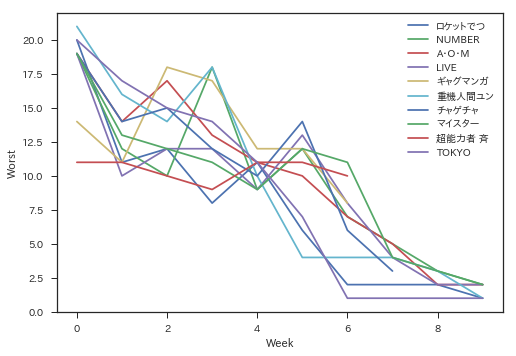

In [4]:
for title in wj.short_end_titles[-10:]:
    plt.plot(wj.extract_item(title)[:10], label=title[:6])
plt.xlabel('Week')
plt.ylabel('Worst')
plt.ylim(0,22)
plt.legend()

あれ？「斉木楠雄」って結構連載していたんじゃ…？こういうときは，`search_title()`を使います．

In [5]:
wj.search_title('斉木', wj.all_titles)

['超能力者 斉木楠雄のΨ難', '斉木楠雄のΨ難']

In [6]:
len(wj.extract_item('超能力者 斉木楠雄のΨ難'))

7

In [7]:
wj.extract_item('超能力者 斉木楠雄のΨ難', 'year'), \
wj.extract_item('超能力者 斉木楠雄のΨ難', 'no')

([2011, 2011, 2011, 2011, 2011, 2011, 2011], [22, 27, 29, 33, 42, 43, 50])

In [8]:
len(wj.extract_item('斉木楠雄のΨ難'))

201

どうやら，「超能力者 斉木楠雄のΨ難」で試験的に7回読み切り掲載したあと，「斉木楠雄のΨ難」の連載を開始したみたいですね（[wikipedia](https://ja.wikipedia.org/wiki/%E6%96%89%E6%9C%A8%E6%A5%A0%E9%9B%84%E3%81%AE%CE%A8%E9%9B%A3)）．
次は，近年のヒット作（独断）の最初の10話分の掲載順を表示します．

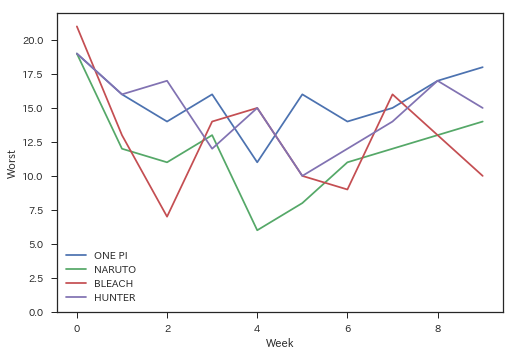

In [9]:
target_titles = ['ONE PIECE', 'NARUTO-ナルト-', 'BLEACH', 'HUNTER×HUNTER']
for title in target_titles:
    plt.plot(wj.extract_item(title)[:10], label=title[:6])
plt.ylim(0,22)
plt.xlabel('Week')
plt.ylabel('Worst')
plt.legend()

個人的に気になったので，50話まで掲載順を見てみます．

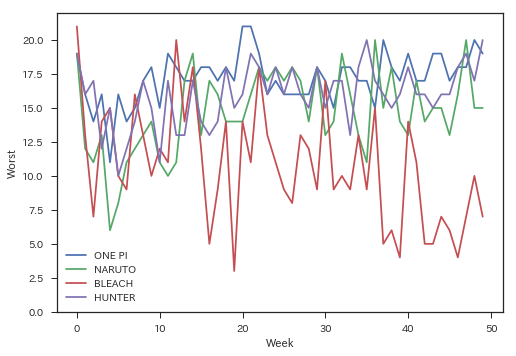

In [10]:
target_titles = ['ONE PIECE', 'NARUTO-ナルト-', 'BLEACH', 'HUNTER×HUNTER']
for title in target_titles:
    plt.plot(wj.extract_item(title)[:50], label=title[:6])
plt.ylim(0,22)
plt.xlabel('Week')
plt.ylabel('Worst')
plt.legend()

ある程度予想はしてましたが，さすがですね．ちなみにですが，`extract_item()`を使ってサブタイトルを取得しながら掲載順を見ると，マンガ好きの方は楽しいと思います．

In [11]:
wj.extract_item('ONE PIECE', 'subtitle')[:10]

['1.ROMANCE DAWN―冒険の夜明け―',
 '第2話!! その男"麦わらのルフィ"',
 '第3話 "海賊狩りのゾロ"登場',
 '第4話 海軍大佐"斧手のモーガン"',
 '第5話 "海賊王と大剣豪"',
 '第6話 "1人目"',
 '第7話 "友達"',
 '第8話 "ナミ登場"',
 '第9話 "魔性の女"',
 '第10話 "酒場の一件"']

さて，`seaborn`で相関分析をやってみます．ここでは，ひとまず6週目までの掲載順をプロットします．同じ座標に複数の点が重なって非常に見づらいので，便宜上ランダムなノイズを加えて見栄えを整えます．なお，1週目を外したのは，ほとんどの場合巻頭に掲載されるためです．

In [12]:
end_data = pd.DataFrame(
    [[wj.extract_item(title)[1] + np.random.randn() * .3,
      wj.extract_item(title)[2] + np.random.randn() * .3,
      wj.extract_item(title)[3] + np.random.randn() * .3,
      wj.extract_item(title)[4] + np.random.randn() * .3,
      wj.extract_item(title)[5] + np.random.randn() * .3,
      '短命作品' if title in wj.short_end_titles else '継続作品']
     for title in wj.end_titles])

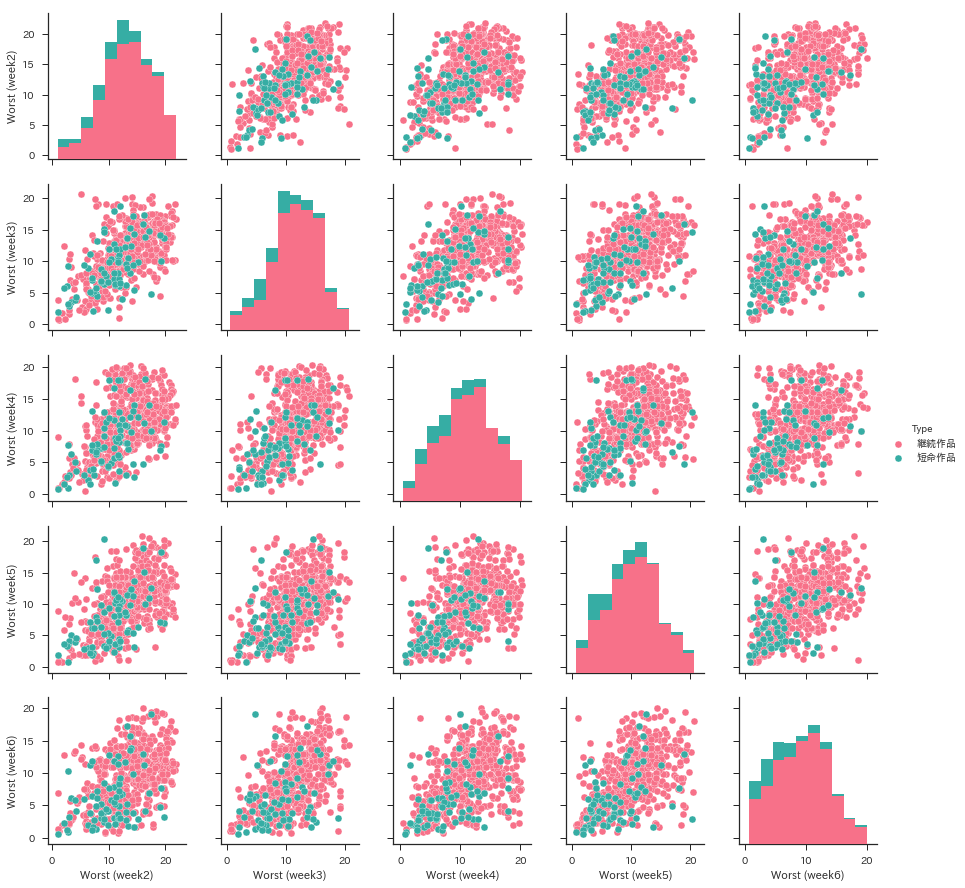

In [13]:
end_data.columns = ["Worst (week2)", "Worst (week3)", "Worst (week4)", 
                    "Worst (week5)", "Worst (week6)", "Type"]
sns.pairplot(end_data, hue="Type", palette="husl")

若干ですが，短命作品は低い掲載順位に集中しがちな傾向があることがわかります．